In [18]:
import networkx as nx
import pandas as pd
import csv
import matplotlib.pyplot as plt
from text_unidecode import unidecode
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np

In [2]:
stationsFileUrl = './biximtl/stations.csv'
rentalsFileUrl = './biximtl/rentals.csv'

In [3]:
# reusable funcs:
reformat_strings = lambda x: unidecode(str.lower(x)).replace(' ','_')

In [4]:
# create graph
graph = nx.Graph()

In [5]:
# format stations csv file (lowercase, remove accents and spaces)
# create graph nodes with station codes as label and name,lat,long,is_member as node properties
with open(stationsFileUrl,newline='') as stationscsvfile:
    stationscsvreader = csv.reader(stationscsvfile)
    firstLine = True
    for row in stationscsvreader:
        if firstLine:
            firstLine = False
            continue
    
        isStationPublic = row[4]
        stationLatitude = row[2]
        stationLongitude = row[3]
        stationCode = row[0]
        stationName = unidecode(str.lower(row[1])).replace(' ','_')
        graph.add_node(stationCode,stationName=stationName,stationLongitude=stationLongitude,stationLatitude=stationLatitude,isStationPublic=isStationPublic)

In [7]:
# create vertices using rental stations start code, as well as end rental station code, and add edge attributes (is_member and rentat time in seconds)
with open(rentalsFileUrl,newline='') as rentalscsvfile:
    rentalscsvreader = csv.reader(rentalscsvfile)
    firstLine = True
    for row in rentalscsvreader:
        if firstLine:
            firstLine = False
            continue
        startStationCode = row[2]
        endStationCode = row[4]
        rentalDurationSec = row[5]
        is_member = row[6]
        graph.add_edge(startStationCode,endStationCode,rentalDurationSec=rentalDurationSec,is_member=is_member)

/Users/alexandrutodea/.conda/envs/alex-ts/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


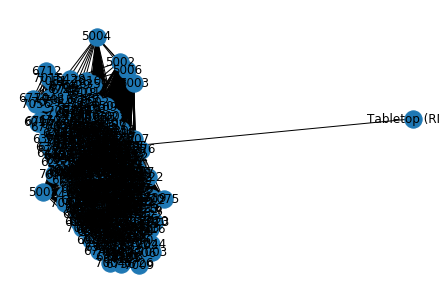

In [8]:
nx.draw(graph, with_labels=True)

In [10]:
# graph overall details
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 547
Number of edges: 108665
Average degree: 397.3126


In [12]:
# precompute probabilities and generate walks
node2vec = Node2Vec(graph,dimensions=20,walk_length=16,num_walks=100,workers=2)

Computing transition probabilities: 100%|██████████| 547/547 [04:47<00:00,  1.90it/s]


In [13]:
# embed nodes
model = node2vec.fit(window=10,min_count=1,batch_words=4)

In [14]:
model.wv.most_similar('7081')

[('6433', 0.9682207703590393),
 ('6091', 0.9656882882118225),
 ('6354', 0.953254759311676),
 ('6436', 0.9521877765655518),
 ('7058', 0.9507097005844116),
 ('7053', 0.9457275867462158),
 ('6706', 0.9456582069396973),
 ('7060', 0.944526731967926),
 ('7076', 0.9444396495819092),
 ('6341', 0.9443648457527161)]

In [15]:
# save embeddings for later use
model.wv.save_word2vec_format('./bicicle_rentals_embeddings.emb')

In [16]:
# save model for later use
model.save('./bicicle_rentals_model.model')

In [19]:
# separate station_nodes and embeddings for visualization purposes
station_nodes = [x for x in model.wv.vocab]
embeddings = np.array([model.wv[x] for x in station_nodes])

In [29]:
tsne = TSNE(n_components=2,random_state=7,perplexity=17)
embeddings_2d = tsne.fit_transform(embeddings)

In [30]:
print(embeddings_2d)

[[ 28.931494    1.9686052]
 [ 16.227724   -1.8067256]
 [-19.952143   -5.5940204]
 ...
 [-31.887848   28.488039 ]
 [ 17.549511  -35.034348 ]
 [ 14.565233  -37.13761  ]]


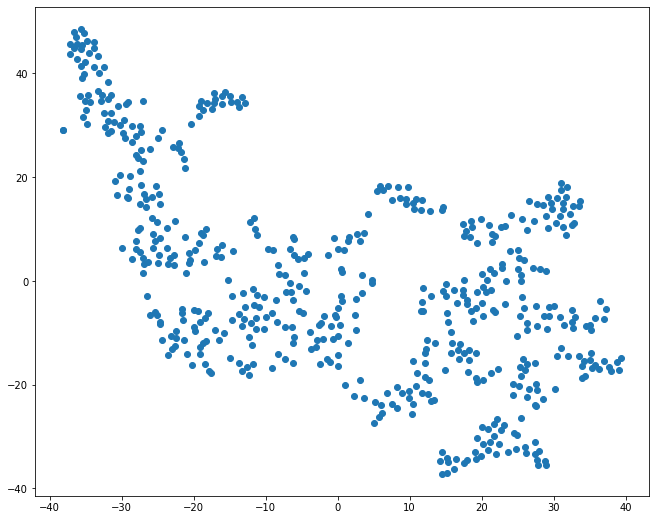

In [31]:
figure = plt.figure(figsize=(11, 9))
ax = figure.add_subplot(111)
ax.scatter(embeddings_2d[:,0],embeddings_2d[:,1])